In [3]:
import numpy as np

from system import (
    states,
    actions,
    num_states,
    num_actions,
    wind_col,
    to_idx,
    get_valid_actions,
    init_mdp,
    init_reward,
    rows,
    cols,
)

from model import Model
from policy import Policy, PolicyInit

In [4]:
def EvaluatePolicy(
    policy: Policy, valf: np.ndarray, model: Model, thresh=0.01, gamma=1.0
):
    i = 0
    delta = thresh + 1
    while delta > thresh and i < 1000:
        delta = 0
        for s in states:
            v = valf[to_idx(s)]
            a = policy.get_action(s)

            valf[to_idx(s)] = model.prob(s, a) @ (model.get_reward(s) + gamma * valf)

            delta = max(delta, abs(v - valf[to_idx(s)]))
        i += 1
    return valf

In [5]:
def UpdatePolicy(policy: Policy, valf: np.ndarray, model: Model, gamma=1.0):
    policy_stable = True
    k = 0
    changed_policies = []
    for s in states:
        old_action = policy.get_action(s)
        valid_actions_idx = get_valid_actions(s, idx=True)
        action_value = [
            model.prob(s, a) @ (model.get_reward(s) + gamma * valf)
            for a in valid_actions_idx
        ]
        # amzt = np.random.choice(valid_actions_idx[action_value == np.max(action_value)])
        amzt = valid_actions_idx[np.argmax(action_value)]
        
        if(valf[to_idx(s)] <= np.max(action_value)):
            policy.set_action(s, amzt)
            if old_action != policy.get_action(s):
                changed_policies.append(s)
                k += 1
                policy_stable = False
    print(f"Policy changed for {k} states")
    print(f"Changed policies: {changed_policies}")
    return policy_stable

In [6]:
# Initialize model
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_state=np.array([3, 7]), t_reward=0)
model = Model(mdp, reward)

# Initialize policy
policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

In [7]:
for s in states:
    policy.set_action(s, policy.gen_action_idx(s))

In [8]:
# Initialize random state function
valf = np.random.uniform(0, 2, size=num_states)
valf_store = []
valf_store.append(valf.copy())

thresh = 0.01
gamma = 0.9

policy_stable = False
i = 0
while (not policy_stable) and i < 1000:
    print(f"Policy Iteration {i + 1}")

    # Policy Evaluation
    print("Evaluating Policy")
    valf = EvaluatePolicy(policy, valf, model, thresh, gamma)
    valf_store.append(valf)

    # Policy Improvement
    print("Updating Policy")
    policy_stable = UpdatePolicy(policy, valf, model, gamma)
    i += 1


Policy Iteration 1
Evaluating Policy
Updating Policy
Policy changed for 53 states
Changed policies: [array([0, 1]), array([0, 2]), array([0, 3]), array([0, 5]), array([0, 7]), array([0, 9]), array([1, 0]), array([1, 1]), array([1, 3]), array([1, 4]), array([1, 7]), array([1, 9]), array([2, 1]), array([2, 2]), array([2, 3]), array([2, 4]), array([2, 5]), array([2, 6]), array([3, 0]), array([3, 1]), array([3, 3]), array([3, 4]), array([3, 5]), array([3, 6]), array([3, 8]), array([3, 9]), array([4, 0]), array([4, 1]), array([4, 2]), array([4, 3]), array([4, 4]), array([4, 5]), array([4, 6]), array([4, 7]), array([4, 9]), array([5, 0]), array([5, 1]), array([5, 2]), array([5, 3]), array([5, 4]), array([5, 5]), array([5, 6]), array([5, 7]), array([5, 8]), array([6, 0]), array([6, 1]), array([6, 2]), array([6, 3]), array([6, 4]), array([6, 5]), array([6, 6]), array([6, 7]), array([6, 8])]
Policy Iteration 2
Evaluating Policy
Updating Policy
Policy changed for 43 states
Changed policies: [arr

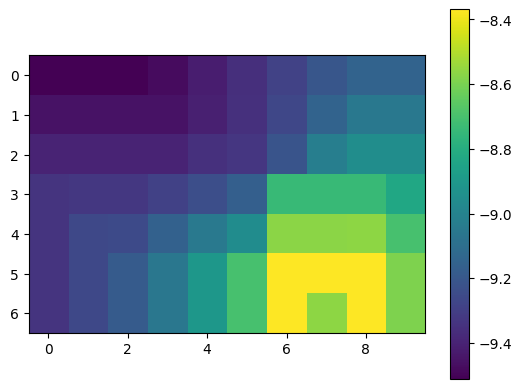

In [9]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

In [10]:
valf_store = np.array(valf_store)
valf_store = valf_store.T
print(valf_store.shape)

(70, 8)


In [11]:
# Run agent
score = 0
steps = 0
s = np.array([3,0])

path = [s]

while(steps < 1000):
    a = policy.get_action(s)

    s_ = model.gen_next(s, a)
    path.append(s_)

    r = model.get_reward(s, s_)
    score += r
    print(f"State: {s}, Action: {actions[a]}, Next State: {s_}, Reward: {r}")
    # print(f"Sussy step: {model.prob(s, a)}")

    if(r!= -1):
        print(f"Game Over - Score: {score}")
        break
    
    s = s_
    steps += 1

State: [3 0], Action: [1 1], Next State: [4 1], Reward: -1
State: [4 1], Action: [1 1], Next State: [5 2], Reward: -1
State: [5 2], Action: [1 1], Next State: [5 3], Reward: -1
State: [5 3], Action: [1 1], Next State: [5 4], Reward: -1
State: [5 4], Action: [1 1], Next State: [5 5], Reward: -1
State: [5 5], Action: [1 1], Next State: [3 6], Reward: -1
State: [3 6], Action: [1 1], Next State: [2 7], Reward: -1
State: [2 7], Action: [1 1], Next State: [3 8], Reward: -1
State: [3 8], Action: [ 1 -1], Next State: [1 7], Reward: -1
State: [1 7], Action: [1 1], Next State: [0 8], Reward: -1
State: [0 8], Action: [1 1], Next State: [1 9], Reward: -1
State: [1 9], Action: [1 0], Next State: [2 9], Reward: -1
State: [2 9], Action: [1 0], Next State: [3 9], Reward: -1
State: [3 9], Action: [1 0], Next State: [4 9], Reward: -1
State: [4 9], Action: [ 1 -1], Next State: [3 8], Reward: -1
State: [3 8], Action: [ 1 -1], Next State: [3 7], Reward: 0
Game Over - Score: -15


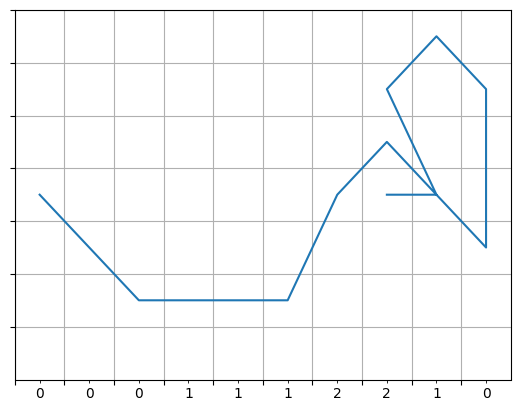

In [12]:
path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()